# MAC0460 / MAC5832 (2020)
<hr>

## EP5: Neural Networks

The goal of this EP is to train and validate multiple architectures of neural networks
(of the multilayer perceptron type) on the training set of MNIST, then choose one model, and
finally evaluate its performance on the test set.

### Topics / concepts explored in this EP:
- scikit-learn (https://scikit-learn.org/)
- neural networks (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- model selection, based on cross-validation


In [1]:
#import the libraries
from tensorflow.keras.datasets import mnist
import numpy as np

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor


# Part 1: Data preparation #

### Download the MINST dataset
[1]: François Chollet and others, Keras, https://keras.io, 2015

In [2]:
#save the dataset to a vector
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()

### Constructing the reduced training set

In [3]:
n = 2000

#chooses 2000 random examples of each class
X_train=np.empty((0, 28, 28))
y_train=np.empty(0, int)
for i in range (0,10):
    index = np.array(np.where(y_train_all==i))
    tmp=np.random.choice(index[0], n, replace=False)
    X_train = np.concatenate((X_train, X_train_all[tmp]), axis=0)
    y_train = np.append(y_train, y_train_all[tmp])

#normalizes the image values
X_train=X_train/255
print(X_train.shape, y_train.shape)
print (y_train)

(20000, 28, 28) (20000,)
[0 0 0 ... 9 9 9]


### Shuffling the dataset
The shuffle function here was taken from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

In [4]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
shuffle_in_unison(X_train, y_train)

### Visualization of the training set  

Data type of the training set: float64 int64
Data type of the testing set: uint8 uint8
Shape of the training set: (20000, 28, 28) (20000,)
Shape of the testing set: (10000, 28, 28) (10000,)
Minima of the training set: X: 0.0 y: 0
Maxima of the training set: X: 1.0 y: 9
Minima of the testing set: X: 0 y: 0
Maxima of the testing set: X: 255 y: 9


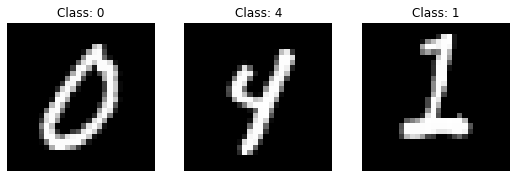

In [5]:
print("Data type of the training set:", X_train.dtype, y_train.dtype)
print("Data type of the testing set:", X_test.dtype, y_test.dtype)

print("Shape of the training set:", X_train.shape, y_train.shape)
print("Shape of the testing set:", X_test.shape, y_test.shape)

print("Minima of the training set: X:", np.min(X_train), "y:", np.min(y_train))
print("Maxima of the training set: X:", np.max(X_train), "y:", np.max(y_train))

print("Minima of the testing set: X:", np.min(X_test), "y:", np.min(y_test))
print("Maxima of the testing set: X:", np.max(X_test), "y:", np.max(y_test))

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize = (9, 6))

for i in range (3):
    k=np.random.randint(low=1, high=20000)
    ax[i].imshow(X_train[k], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title("Class: %d"%y_train[k])
    
plt.show()

In [6]:
#Flatens the X_train and X_test array

X_train=np.reshape(X_train, (20000, 784))
print ("Shape of the flatened X_train vector:", X_train.shape)
X_test=np.reshape(X_test, (10000, 784))
print ("Shape of the flatened X_test vector:", X_test.shape)

Shape of the flatened X_train vector: (20000, 784)
Shape of the flatened X_test vector: (10000, 784)


# Part 2: Model selection
### Now we define our models and train them.
- **Ichi** is the mandatory architecture, used in https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/2.1-a-first-look-at-a-neural-network.ipynb.
- **Ni** is the architecture used in this 3Blue1Brown video: https://www.youtube.com/watch?v=aircAruvnKk, because it's a well done video from a YouTube channel I like.
- **San** has three hidden layers with a triangular shape (256,128,64,32), a ReLU activation function, and the Adam optimization algorithm. These last two are the default parameters of the sklearn.neural_network.MLPClassifier function.

In [7]:
#Setting up the stratified cross validation

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(5)

skf.get_n_splits(X_train, y_train)

5

In [9]:
import pandas as pd
from keras.utils import to_categorical

def train_network(net, k_fold, train_X, train_y):
    #trains a network keeping a history of its cross validation folds scores
    
    n_fold = 1
    
    train_score_history = []
    test_score_history = []
    
    for i, j in k_fold.split(train_X, train_y):
        
        print(f"FOLD NUMBER: {n_fold}")
        n_fold += 1
        
        print(25*'-'+'Class distribution on the training set')
        print(pd.Series(train_y[i]).value_counts())
        
        print(25*'-'+'Class distribution on the test set')
        print(pd.Series(train_y[j]).value_counts())
        
        train_y_cat = to_categorical(train_y)
        
        fold_train_X, fold_test_X = train_X[i], train_X[j]
        fold_train_y, fold_test_y = train_y_cat[i], train_y_cat[j]
        
        
        net.fit(fold_train_X, fold_train_y)
        
        print(25*'-'+'SCORING TEST SET..')
        train_score = net.score(fold_train_X, fold_train_y)
        test_score = net.score(fold_test_X, fold_test_y)
        print(f'Train score: {train_score}')
        print(f'Test score: {test_score}')
        
        train_score_history.append(train_score)
        test_score_history.append(test_score)
        
        
        if n_fold<5:
            print('-'*40+'NEXT FOLD'+'-'*40)
        
        
    
    return pd.DataFrame({'Train Scores':train_score_history,'Test Scores':test_score_history})



Using TensorFlow backend.


In [44]:
#Instatianting the models
ichi = MLPClassifier(hidden_layer_sizes=(512), activation='relu', solver='adam', max_iter=50)
ni = MLPClassifier(hidden_layer_sizes=(16,16), activation='tanh', solver='sgd', max_iter=50)
san = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation='relu', solver='adam', max_iter=50)

#training the networks
ichi_data = train_network(ichi, skf, X_train, y_train)
ni_data = train_network(ni, skf, X_train, y_train)
san_data = train_network(san, skf, X_train, y_train)


FOLD NUMBER: 1
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 1.0
Test score: 0.9445
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 2
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 1.0
Test score: 0.9475
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 3
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 1.0
Test score: 0.938
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 4
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 1.0
Test score: 0.9415
FOLD NUMBER: 5
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 1.0
Test score: 0.9495
FOLD NUMBER: 1
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 0.799875
Test score: 0.79425
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 2
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 0.78775
Test score: 0.78725
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 3
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 0.807625
Test score: 0.7895
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 4
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 0.795875
Test score: 0.7895
FOLD NUMBER: 5
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64


/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------SCORING TEST SET..
Train score: 0.78075
Test score: 0.7795
FOLD NUMBER: 1
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64
-------------------------SCORING TEST SET..
Train score: 1.0
Test score: 0.95325
----------------------------------------NEXT FOLD----------------------------------------
FOLD NUMBER: 2
-------------------------Class distribution on the training set
7    1600
6    1600
5    1600
4    1600
3    1600
2    1600
9    1600
1    1600
8    1600
0    1600
dtype: int64
-------------------------Class distribution on the test set
9    400
7    400
5    400
3    400
1    400
8    400
6    400
4    400
2    400
0    400
dtype: int64
-------------------------SCORING TE

In [24]:
#ichi network scores
ichi_data.describe()

,Train Scores,Test Scores
count,5.0,5.000000
mean,1.0,0.943750
std,0.0,0.002878
min,1.0,0.939750
25%,1.0,0.942000
50%,1.0,0.944250
75%,1.0,0.946250
max,1.0,0.946500


In [45]:
#ni network scores
ni_data.describe()

,Train Scores,Test Scores
count,5.000000,5.000000
mean,0.794375,0.788000
std,0.010459,0.005394
min,0.780750,0.779500
25%,0.787750,0.787250
50%,0.795875,0.789500
75%,0.799875,0.789500
max,0.807625,0.794250


In [26]:
#san network scores
san_data.describe()

,Train Scores,Test Scores
count,5.0,5.000000
mean,1.0,0.953700
std,0.0,0.002636
min,1.0,0.950000
25%,1.0,0.952000
50%,1.0,0.954500
75%,1.0,0.956000
max,1.0,0.956000


# Part 3: Model evaluation

The **ichi** and **san** networks have similar results, with **san** having slightly less error, so this is the network that will be used.

In [39]:
san = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation='relu', solver='adam', max_iter=10) #Here i set the maximum number of iteractions to 10 to be able to calculate the learning curve quicker
san.fit(X_train,y_train)

/home/samir/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 128, 64, 32), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [41]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(san, 
                                                        X_train, 
                                                        y_train,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

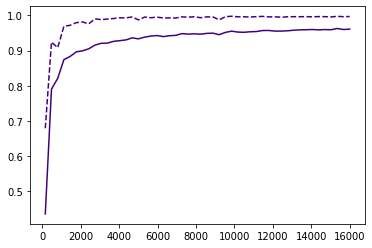

In [43]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#400080",  label="Training score")
plt.plot(train_sizes, test_mean, color="#400080", label="Cross-validation score")

# Create plot
plt.show()

In [40]:
#Value counts in the test set
print("Number of examples of each class on the test set:\n")
print(pd.Series(y_test).value_counts())

Number of examples of each class on the test set:

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

#Plotting the confusion matrix, and also a classification report
predict_train = san.predict(X_train)
predict_test = san.predict(X_test)
print("Confusion Matrix:\n\n", confusion_matrix(y_test, predict_test))
print("\nClassification report:\n\n", classification_report(y_test, predict_test))

Confusion Matrix:

 [[ 969    0    2    0    0    0    3    3    3    0]
 [   0 1127    2    0    0    0    2    2    2    0]
 [   7    3  999    6    1    1    1    9    5    0]
 [   1    0    6  984    1    3    0    7    7    1]
 [   2    1    4    0  950    0    3    7    3   12]
 [   3    0    0   11    1  863    4    2    3    5]
 [   6    3    1    0    4   10  933    0    1    0]
 [   1    4    8    4    0    0    0 1005    0    6]
 [   2    1    4    9    3    4    3    5  941    2]
 [   2    2    0    9    6    1    2   14    3  970]]

Classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.97      0.98 